# GRANDMA/Kilonova-catcher --- KN-Mangrove

The purpose of this notebook is to inspect the ZTF alerts that were selected by the Fink KN-Mangrove filter as potential Kilonova candidates in the period 2021/04/01 to 2021/08/31, and forwarded to the GRANDMA/Kilonova-catcher project for follow-up observations.

With the other filter (KN-LC), we need at least two days to identify a candidate. It may seem like a short amount of time, but if the object is a kilonova, it will already be fading or even too faint to be observed. The second filter aims to tackle younger detections. An alert will be considered as a candidate if, on top of the other cuts, one can identify a suitable host and the resulting absolute magnitude is compatible with the kilonovae models.
To identify possible hosts, we used the MANGROVE catalog [1]. It is an inventory of 800,000 galaxies. At this point, we are only interested in their position in the sky: right ascension, declination, and luminosity distance. We only considered the galaxies in a 230 Mpc range, as it is the current observation range of the gravitational waves interferometers.

This filter uses the following cuts:
- Point-like object: the star/galaxy extractor score must be above 0.4. This could be justified by saying that the alert should be a point-like object. Actually, few objects score below 0.4 given the current implementation, and objects that do are most likely boguses.
- Non-artefact: the deep real/bogus score must be above 0.5.
- Object non referenced in SIMBAD catalog (galactic ones).
- Young detection: less than 6 hours.
- Galaxy association: The alert should within 10 kpc of a galaxy from the Mangrove catalog.
- Absolute magnitude: the absolute magnitude of the alert should be −16 ± 1.

According to [2], we expect a kilonova event to display an absolute magnitude of −16 ± 1. We don’t know the distance of the alerts in general, so we will compute the absolute magnitude of an alert as if it were in a given galaxy. This threshold is given in the band g but it was implemented and band g and r without distinction. This hypothesis is due to the lack of observations.

The galaxy association method is also not perfect: it can lead to the mis-association of an event that is in the foreground or the background of a galaxy. But this is necessary as the luminosity distance between the earth and the alert is usually unknown.


[1] J-G Ducoin et al. “Optimizing gravitational waves follow-up using galaxies stellar mass”. In: Monthly Notices of the Royal Astronomical Society 492.4 (Jan. 2020), pp. 4768–4779. issn: 1365-2966. doi: 10.1093/mnras/staa114. url: http://dx.doi.org/10.1093/ mnras/staa114.

[2] Mansi M. Kasliwal et al. “Kilonova Luminosity Function Constraints Based on Zwicky Transient Facility Searches for 13 Neutron Star Merger Triggers during O3”. In: The Astrophysical Journal 905.2 (Dec. 2020), p. 145. issn: 1538-4357. doi: 10.3847/1538- 4357/abc335. url: http://dx.doi.org/10.3847/1538-4357/abc335.

In [1]:
import os
import requests

import pandas as pd
import numpy as np

from astropy.coordinates import SkyCoord
from astropy import units as u

# pip install fink_filters
from fink_filters import __file__ as fink_filters_location

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_context('talk')

APIURL = 'https://fink-portal.org'

## KN-Mangrove data

Let's load the alert data from this filter:

In [3]:
pdf_kn_ma = pd.read_parquet('data/0104_3009_kn_filter2_class.parquet')

nalerts_kn_ma = len(pdf_kn_ma)
nunique_alerts_kn_ma = len(np.unique(pdf_kn_ma['objectId']))

print(
    '{} alerts loaded ({} unique objects)'.format(
        nalerts_kn_ma, 
        nunique_alerts_kn_ma
    )
)

68 alerts loaded (59 unique objects)


## Visualising the candidates

Finally, let's inspect one lightcurve:

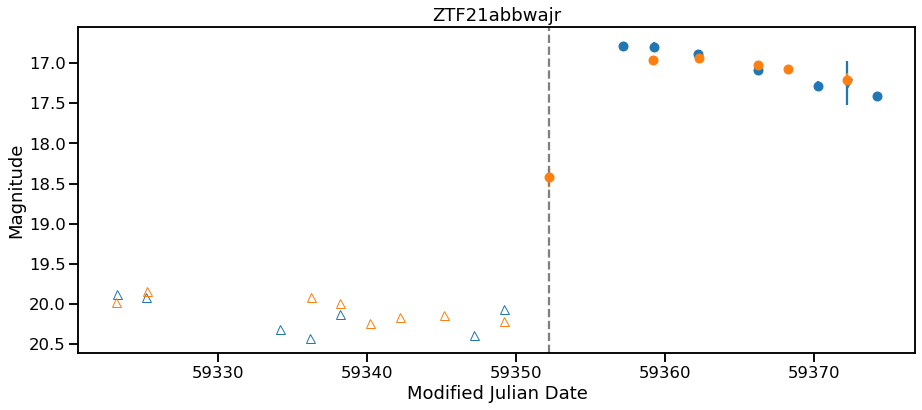

https://fink-portal.org/ZTF21abbwajr


In [4]:
oid = pdf_kn_ma['objectId'].values[2]
tns_class = pdf_kn_ma['TNS'].values[2]
kn_trigger = pdf_kn_ma['candidate'].apply(lambda x: x['jd']).values[2]

r = requests.post(
  '{}/api/v1/objects'.format(APIURL),
  json={
    'objectId': oid,
    'withupperlim': 'True'
  }
)

# Format output in a DataFrame
pdf = pd.read_json(r.content)

fig = plt.figure(figsize=(15, 6))

colordic = {1: 'C0', 2: 'C1'}

for filt in np.unique(pdf['i:fid']):
    maskFilt = pdf['i:fid'] == filt

    # The column `d:tag` is used to check data type
    maskValid = pdf['d:tag'] == 'valid'
    plt.errorbar(
        pdf[maskValid & maskFilt]['i:jd'].apply(lambda x: x - 2400000.5),
        pdf[maskValid & maskFilt]['i:magpsf'],
        pdf[maskValid & maskFilt]['i:sigmapsf'],
        ls = '', marker='o', color=colordic[filt]
    )

    maskUpper = pdf['d:tag'] == 'upperlim'
    plt.plot(
        pdf[maskUpper & maskFilt]['i:jd'].apply(lambda x: x - 2400000.5),
        pdf[maskUpper & maskFilt]['i:diffmaglim'],
        ls='', marker='^', color=colordic[filt], markerfacecolor='none'
    )

    maskBadquality = pdf['d:tag'] == 'badquality'
    plt.errorbar(
        pdf[maskBadquality & maskFilt]['i:jd'].apply(lambda x: x - 2400000.5),
        pdf[maskBadquality & maskFilt]['i:magpsf'],
        pdf[maskBadquality & maskFilt]['i:sigmapsf'],
        ls='', marker='v', color=colordic[filt]
    )

plt.axvline(kn_trigger - 2400000.5, ls='--', color='grey')
plt.gca().invert_yaxis()
plt.xlabel('Modified Julian Date')
plt.ylabel('Magnitude')
plt.title('{}'.format(oid))
plt.show()
print('{}/{}'.format(APIURL, oid))

Circles (●) with error bars show valid alerts that pass the Fink quality cuts. Upper triangles with errors (▲), representing alert measurements that do not satisfy Fink quality cuts, but are nevetheless contained in the history of valid alerts and used by classifiers. Lower triangles (▽), representing 5-sigma mag limit in difference image based on PSF-fit photometry contained in the history of valid alerts. The vertical line shows the KN trigger by Fink.

## Evolution of the classification

Each alert was triggered because the Fink pipelines favoured the KN flavor at the time of emission. But the underlying object on the sky might have generated further alerts after, and the classification could evolve. For a handful of alerts, let see what they became. For this, we will use the Fink REST API, and query all the data for the underlying object:

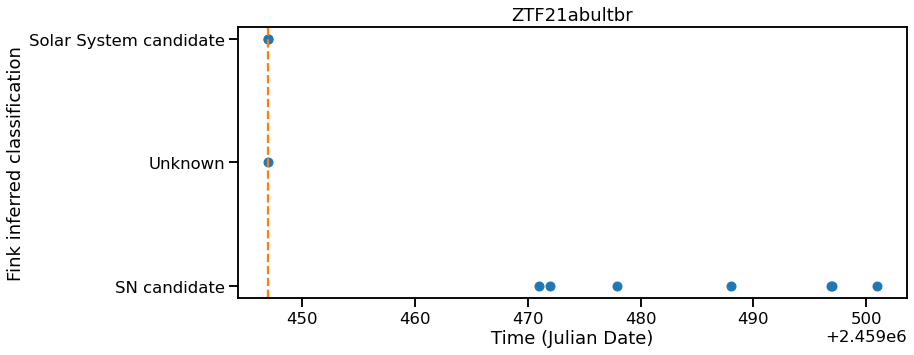

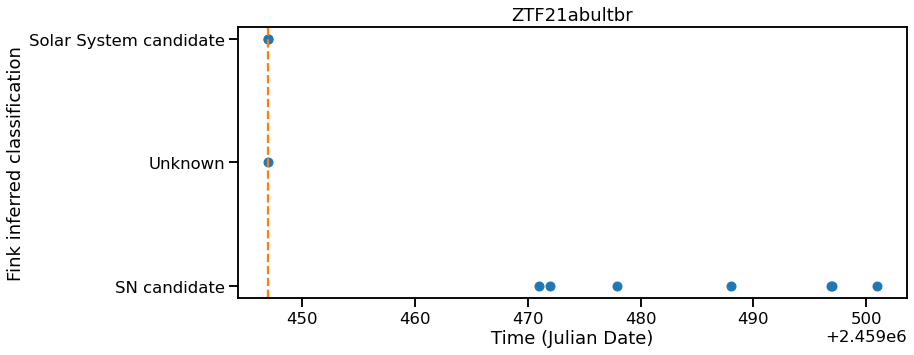

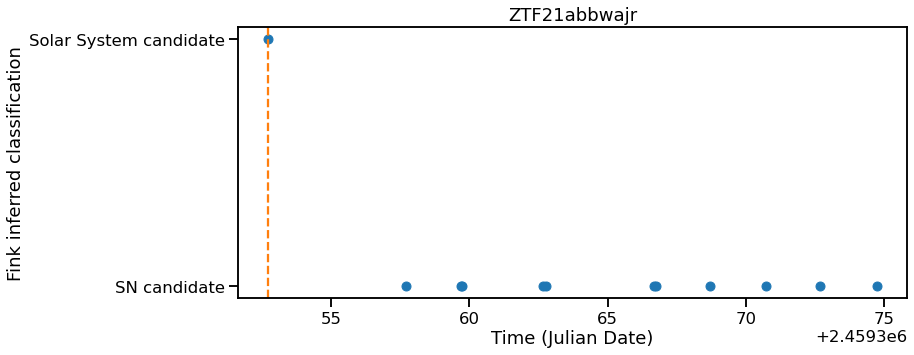

In [5]:
NALERTS = 3
oids = pdf_kn_ma['objectId'].values[0: NALERTS]
kn_triggers = pdf_kn_ma['candidate'].apply(lambda x: x['jd']).values[0: NALERTS]

for oid, kn_trigger in zip(oids, kn_triggers):
    r = requests.post(
      '{}/api/v1/objects'.format(APIURL),
      json={
        'objectId': oid,
        'output-format': 'json'
      }
    )

    # Format output in a DataFrame
    pdf_ = pd.read_json(r.content)
    times, classes = np.transpose(pdf_[['i:jd','v:classification']].values)
    
    fig = plt.figure(figsize=(12, 5))
    
    plt.plot(times, classes, ls='', marker='o')
    plt.axvline(kn_trigger, ls='--', color='C1')
    
    plt.title(oid)
    plt.xlabel('Time (Julian Date)')
    plt.ylabel('Fink inferred classification')
    plt.show()

Note that Kilonova classification does not appear here as this label is reserved to the KN-LC filter. We are working on giving a new label. 

One can see that alert classification for a given object can change over time. With time, we collect more data, and have a clearer view on the nature of the object. Let's make an histogram of the final classification for each object (~1min to run)

In [6]:
final_classes = []
oids = np.unique(pdf_kn_ma['objectId'].values)
for oid in oids:
    r = requests.post(
      '{}/api/v1/objects'.format(APIURL),
      json={
        'objectId': oid,
        'output-format': 'json'
      }
    )
    pdf_ = pd.read_json(r.content)
    final_classes.append(pdf_['v:classification'].values[0])

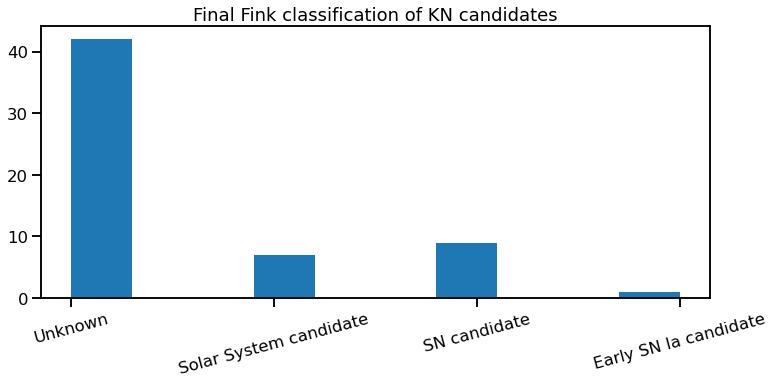

In [7]:
fig = plt.figure(figsize=(12, 5))

plt.hist(final_classes)

plt.xticks(rotation=15.)
plt.title('Final Fink classification of KN candidates');

Most of the objects are still unknown according to Fink.

## Follow-up of candidates by other instruments

Some of the alerts benefited from follow-up by other instruments to determine their nature. Usually this information can be found on the TNS server (although this is highly biased towards Supernovae). We attached this information to the alerts (if it exists):

In [8]:
pdf_kn_ma.groupby('TNS').count().sort_values('objectId', ascending=False)['objectId']

TNS
                   51
SN Ia               5
SN II               4
SN IIP              3
SN Ia-91bg-like     2
SN IIb              1
SN Ib               1
SN Ic               1
Name: objectId, dtype: int64

We can see that among all 53 alerts forwarded by Fink, 39 have no known counterpart in TNS (i.e. no follow-up result was reported). 

## Retrieving  Mangrove data

In [9]:
catalog_path = os.path.join(os.path.dirname(fink_filters_location), 'data/mangrove_filtered.csv')
pdf_mangrove = pd.read_csv(catalog_path)

In [10]:
pdf_mangrove.head(2)

,HyperLEDA_name,2MASS_name,ra,dec,lum_dist,dist_err,stellarmass,ang_dist
0,b'None',b'None',279.101,-23.90333,0.002698,NaN,NaN,0.002698
1,b'None',b'None',271.834,-24.99750,0.002698,NaN,NaN,0.002698


In [11]:
# ZTF
ra1 = pdf_kn_ma['candidate'].apply(lambda x: x['ra'])
dec1 = pdf_kn_ma['candidate'].apply(lambda x: x['dec'])

# Mangrove
cols = ['internal_names', 'ra', 'declination', 'discoverydate', 'type']
ra2, dec2, name, lum_dist, ang_dist = pdf_mangrove['ra'], pdf_mangrove['dec'], pdf_mangrove['2MASS_name'], pdf_mangrove['lum_dist'], pdf_mangrove['ang_dist']

# create catalogs
catalog_ztf = SkyCoord(ra=ra1.values*u.degree, dec=dec1.values*u.degree)
catalog_tns = SkyCoord(ra=np.array(ra2, dtype=np.float)*u.degree, dec=np.array(dec2, dtype=np.float)*u.degree)

# cross-match
idx, d2d, d3d = catalog_ztf.match_to_catalog_sky(catalog_tns)

pdf_kn_ma['2MASS_name'] = name.values[idx]

pdf_kn_ma['separation (Kpc)'] = d2d.radian * ang_dist.values[idx] * 1000

pdf_kn_ma['lum_dist (Mpc)'] = lum_dist.values[idx]

/Users/julien/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  # This is added back by InteractiveShellApp.init_path()


In [12]:
pdf_kn_ma[['objectId', '2MASS_name', 'separation (Kpc)', 'lum_dist (Mpc)']].head(5)

,objectId,2MASS_name,separation (Kpc),lum_dist (Mpc)
0,ZTF21abultbr,b'07571891+5831153',3.988756,88.245249
1,ZTF21abultbr,b'07571891+5831153',3.977716,88.245249
2,ZTF21abbwajr,b'11395096-0736278',3.284731,96.681767
3,ZTF21abqkiad,b'05575743+2233176',5.817357,79.075132
4,ZTF21abssdnn,b'22304625+7630400',6.284166,29.029202


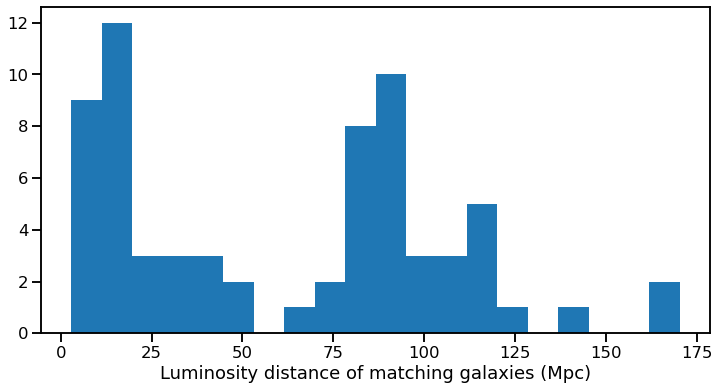

In [13]:
fig = plt.figure(figsize=(12, 6))

plt.hist(pdf_kn_ma['lum_dist (Mpc)'], bins=20)

plt.xlabel('Luminosity distance of matching galaxies (Mpc)');

In [14]:
np.max(pdf_kn_ma['lum_dist (Mpc)'])

170.394318806